<a href="https://colab.research.google.com/github/Akshaypakhle10/ML/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import os
import plotly.express as px
%matplotlib inline
import seaborn as sns

#Web Scraping COVID-19 Data

In [ ]:
def worldometer_scraper(url=''):
    """
    Scrapes "Total Cases" and "Total Deaths" graphs on worldometer.
    Arguments:
    url -- defaults to the main page which has worldwide totals
    """
    base_url = 'https://www.worldometers.info/coronavirus/'
    page = requests.get(base_url + url)
    page = BeautifulSoup(page.text, 'html.parser')

    dates_pattern = 'categories: (.*?)]'
    data_pattern = 'data: (.*?)]'

    case_dates,death_dates = None,None
    #extract data from the U.S graphs on worldometer
    for script in page.find_all('script'):
        text = script.text
        if text.find('Total Cases') + 1:
            case_dates = re.findall(dates_pattern,text)
            cases = re.findall(data_pattern,text)
        if text.find('Total Deaths') + 1:
            death_dates = re.findall(dates_pattern,text)
            deaths = re.findall(data_pattern,text)

    if death_dates:
        death_dates = death_dates[0][1:].replace('"','').split(",")
        deaths = [int(death) for death in deaths[0][1:].replace('"','').split(",")]
        death_df = pd.DataFrame(zip(death_dates,deaths),columns=['date','total deaths'])
    else:
        death_df = pd.DataFrame(columns=['date','total deaths'])

    if case_dates:
        case_dates = case_dates[0][1:].replace('"','').split(",")
        cases = [int(case) for case in cases[0][1:].replace('"','').split(",")]
        case_df = pd.DataFrame(zip(case_dates,cases),columns=['date','total cases'])
    else:
        case_df = pd.DataFrame(columns=['date','total cases'])


    df = pd.merge(case_df,death_df,on='date',how='outer')
    return df


def get_urls():
    """
    Returns Worldometer urls for every available country
    """
    urls = []
    worldometer_page = requests.get("https://www.worldometers.info/coronavirus/")
    worldometer_page = BeautifulSoup(worldometer_page.text, 'html.parser')
    for row in worldometer_page.find_all("tr"):
        for link in row.find_all('a'):
            urls.append(link.get('href'))
    return urls
    


if __name__ == '__main__':

    if not 'worldometer_data' in os.listdir():
        os.mkdir('worldometer_data')

    urls = get_urls()
    for url in urls:
        df = worldometer_scraper(url)
        file_name = '{}.csv'.format(url.split('/')[1])
        path = os.path.join('worldometer_data',file_name)
        df.to_csv(path)

#EDA

In [ ]:
#Reading in data from JHU for 5/06/2020
df = pd.read_csv("/content/drive/My Drive/COVID19/clean_complete/covid_19_clean_complete.csv", parse_dates = ['Date'])
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


### Cursory Analysis

In [ ]:
#Details about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26400 entries, 0 to 26399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  8000 non-null   object        
 1   Country/Region  26400 non-null  object        
 2   Lat             26400 non-null  float64       
 3   Long            26400 non-null  float64       
 4   Date            26400 non-null  datetime64[ns]
 5   Confirmed       26400 non-null  int64         
 6   Deaths          26400 non-null  int64         
 7   Recovered       26400 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.6+ MB


There are 5 numerical columns ('Lat','Long','Confirmed','Deaths','Recovered') 
 , 2 catagorical columns ('Province/State' & 'Country/Region' ) and 1 datetime column ('Date')

In [ ]:
df.describe(include = 'object')

,Province/State,Country/Region
count,8000,26400
unique,80,187
top,Henan,China
freq,100,3300


Going in detail, there are 187 unique countries and 80 unique province/states enlisted in the dataset

In [ ]:
a = df.Date.value_counts().sort_index()
print('The first date is:',a.index[0])
print('The last date is:',a.index[-1])

The first date is: 2020-01-22 00:00:00
The last date is: 2020-04-30 00:00:00


The dataset starts from 22nd January to 30th April 2020

In [ ]:
df.isnull().sum()

Province/State    18400
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

### Cleaning the data a bit

In [ ]:
#Renaming the coulmns for easy usage
df.rename(columns={'Date': 'date', 
                     'Province/State':'state',
                     'Country/Region':'country',
                     'Lat':'lat', 'Long':'long',
                     'Confirmed': 'confirmed',
                     'Deaths':'deaths',
                     'Recovered':'recovered'
                    }, inplace=True)

# Active Case = confirmed - deaths - recovered
df['active'] = df['confirmed'] - df['deaths'] - df['recovered']

## Visualizations

### Worldwide spread analysis:

In [ ]:
#Worldwide spread analysis:
df1 = df
df1['date'] = pd.to_datetime(df1['date'])
df1['date'] = df1['date'].dt.strftime('%m/%d/%Y')
df1 = df1.fillna('-')
fig = px.density_mapbox(df1, lat='lat', lon='long', z='confirmed', radius=20,zoom=1, hover_data=["country",'state',"confirmed"],
                        mapbox_style="carto-positron", animation_frame = 'date', range_color= [0, 2000],title='Spread of Covid-19')
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

Here are my observations :

1) The spread of the virus was initially slow and the numbers were also less.

2) But as time progresses, the spread is massive and the numbers have gone haywire.


### Top 20 countries having most confirmed cases

[Text(0, 0.5, 'Country'), Text(0.5, 0, 'Total cases')]

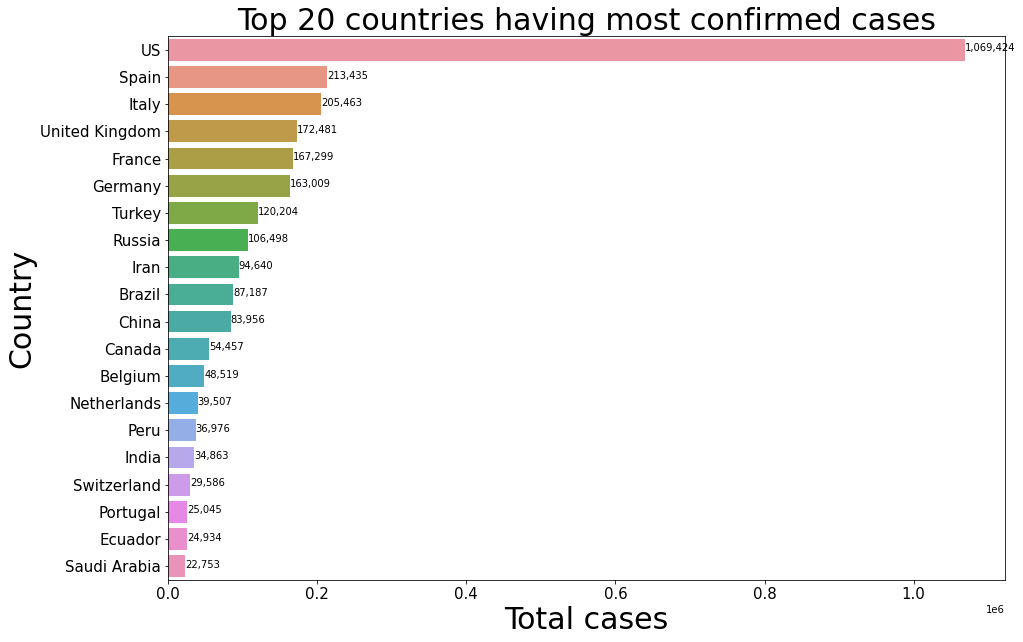

In [ ]:
top = df[df['date'] == df['date'].max()]
top_casualities = top.groupby(by = 'country')['confirmed'].sum().sort_values(ascending = False).head(20).reset_index()

plt.figure(figsize= (15,10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Total cases",fontsize = 30)
plt.ylabel('Country',fontsize = 30)
plt.title("Top 20 countries having most confirmed cases" , fontsize = 30)
ax = sns.barplot(x = top_casualities.confirmed, y = top_casualities.country)
for i, (value, name) in enumerate(zip(top_casualities.confirmed,top_casualities.country)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=10, ha='left',  va='center')
ax.set(xlabel='Total cases', ylabel='Country')

### Active cases around the world:

In [ ]:
# Active cases around the world:
top = df[df['date'] == df['date'].max()]
world = top.groupby('country')['confirmed','active','deaths'].sum().reset_index()
world.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,country,confirmed,active,deaths
0,Afghanistan,2171,1847,64
1,Albania,773,272,31
2,Algeria,4006,1777,450
3,Andorra,745,235,42
4,Angola,27,18,2


In [ ]:
figure = px.choropleth(world, locations="country", 
                    locationmode='country names', color="active", 
                    hover_name="country", range_color=[1,20000], 
                    color_continuous_scale="Peach", 
                    title='Countries with Active Cases')
figure.show()

### Recovered count around the world:

In [ ]:
#Recovered count around the world:
fig = px.scatter_mapbox(top, lat="lat", lon="long", hover_name="country", hover_data=["country","recovered"],
                        color_discrete_sequence=["fuchsia"], zoom=0.5, height=300,title='Recovered count of each country' )
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

Lot of recoveries in the Asian continent and european countries.

### Top 20 countries having most recovered cases

[Text(0, 0.5, 'Country'), Text(0.5, 0, 'Total cases')]

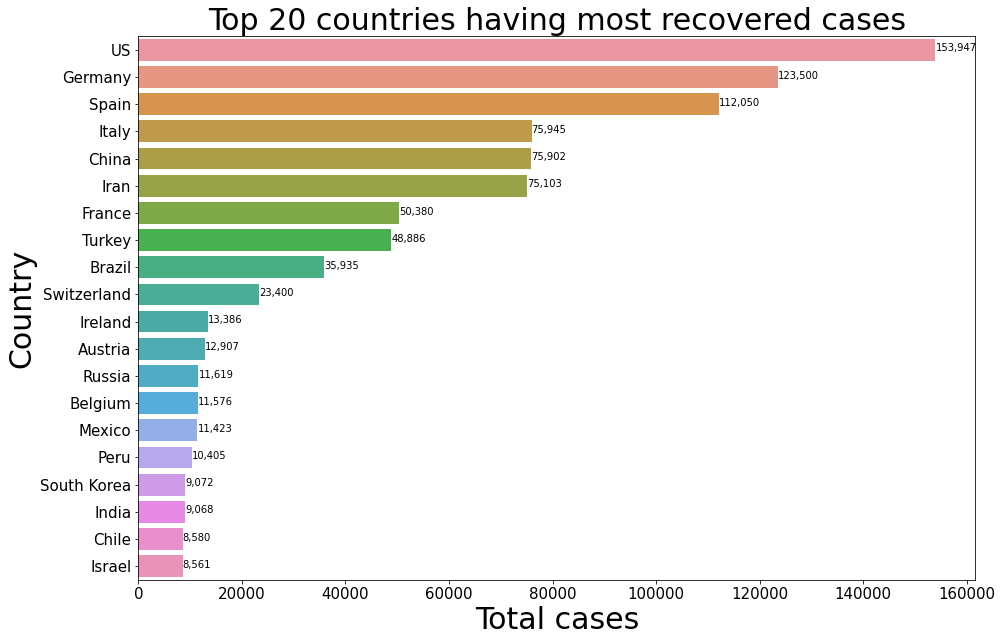

In [ ]:
top_recovered = top.groupby(by = 'country')['recovered'].sum().sort_values(ascending = False).head(20).reset_index()
plt.figure(figsize= (15,10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Total cases",fontsize = 30)
plt.ylabel('Country',fontsize = 30)
plt.title("Top 20 countries having most recovered cases" , fontsize = 30)
ax = sns.barplot(x = top_recovered.recovered, y = top_recovered.country)
for i, (value, name) in enumerate(zip(top_recovered.recovered,top_recovered.country)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=10, ha='left',  va='center')
ax.set(xlabel='Total cases', ylabel='Country')

### Death count around the world:

In [ ]:
world['size'] = world['deaths'].pow(0.2)
fig = px.scatter_geo(world, locations="country",locationmode='country names', color="deaths",
                     hover_name="country", size="size",hover_data = ['country','deaths'],
                     projection="natural earth",title='Death count of each country')
fig.show()

Some of the hardest hit countries are US, Italy, Spain, France, UK. Surprisingly, China is below all these in death tolls!

### Worldwide Confirmed Cases Over Time:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



[Text(0, 0.5, 'Total cases'), Text(0.5, 0, 'Dates')]

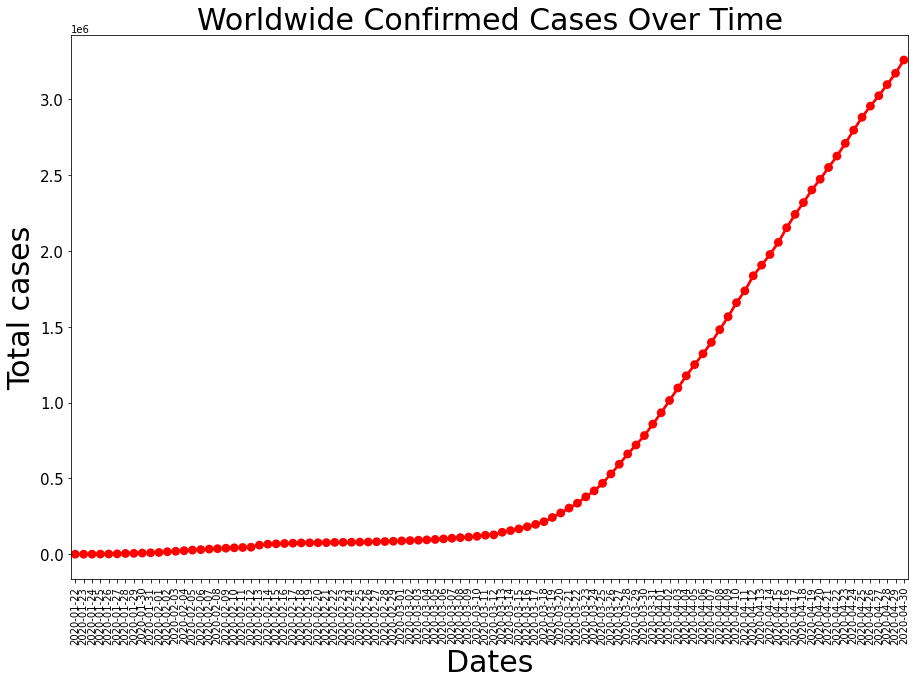

In [ ]:
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 10)
plt.yticks(fontsize = 15)
plt.xlabel("Dates",fontsize = 30)
plt.ylabel('Total cases',fontsize = 30)
plt.title("Worldwide Confirmed Cases Over Time" , fontsize = 30)
total_cases = df.groupby('date')['date', 'confirmed'].sum().reset_index()
total_cases['date'] = pd.to_datetime(total_cases['date'])


ax = sns.pointplot( x = total_cases.date.dt.date ,y = total_cases.confirmed , color = 'r')
ax.set(xlabel='Dates', ylabel='Total cases')

Exponential growth, like in contagion!

### Analysis of most affected countries

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



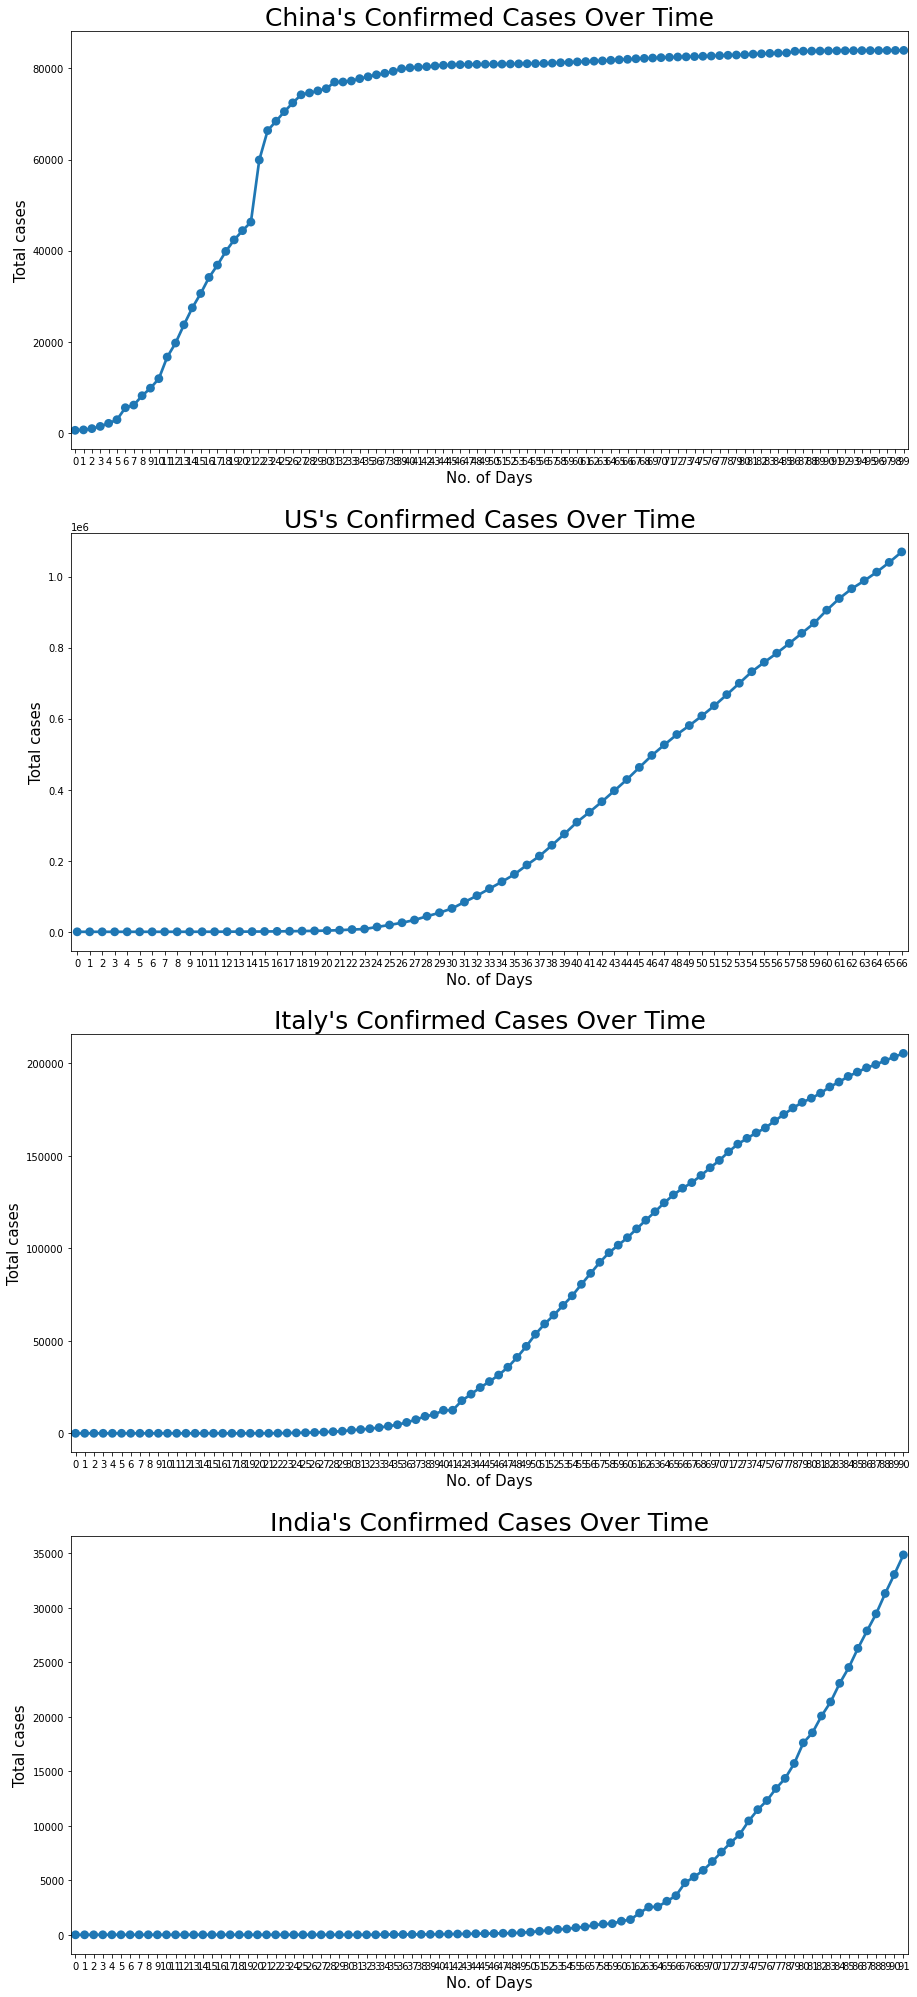

In [ ]:
china =  df[df.country == 'China']
china = china.groupby(by = 'date')['recovered', 'deaths', 'confirmed', 'active'].sum().reset_index()
china.head()

us =  df[df.country == 'US']
us = us.groupby(by = 'date')['recovered', 'deaths', 'confirmed', 'active'].sum().reset_index()
us = us.iloc[33:].reset_index().drop('index', axis = 1)
us.head()

italy =  df[df.country == 'Italy']
italy = italy.groupby(by = 'date')['recovered', 'deaths', 'confirmed', 'active'].sum().reset_index()
italy = italy.iloc[9:].reset_index().drop('index', axis = 1)
italy.head()

india =  df[df.country == 'India']
india = india.groupby(by = 'date')['recovered', 'deaths', 'confirmed', 'active'].sum().reset_index()
india = india.iloc[8:].reset_index().drop('index', axis = 1)
india.head()

plt.figure(figsize=(15,30))
a = plt.subplot(4, 1, 1)
sns.pointplot(china.index ,china.confirmed)
plt.title("China's Confirmed Cases Over Time" , fontsize = 25)
plt.ylabel('Total cases', fontsize = 15)
plt.xlabel('No. of Days', fontsize = 15)

plt.subplot(4, 1, 2)
sns.pointplot(us.index ,us.confirmed)
plt.title("US's Confirmed Cases Over Time" , fontsize = 25)
plt.xlabel('No. of Days', fontsize = 15)
plt.ylabel('Total cases', fontsize = 15)

plt.subplot(4, 1, 3)
sns.pointplot(italy.index ,italy.confirmed)
plt.title("Italy's Confirmed Cases Over Time" , fontsize = 25)
plt.xlabel('No. of Days', fontsize = 15)
plt.ylabel('Total cases', fontsize = 15)

plt.subplot(4, 1, 4)
sns.pointplot(india.index ,india.confirmed)
plt.title("India's Confirmed Cases Over Time" , fontsize = 25)
plt.xlabel('No. of Days', fontsize = 15)
plt.ylabel('Total cases', fontsize = 15)

plt.subplots_adjust(bottom=0.01, top=0.9)

#Fitting Logistic Curves

In [ ]:
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import scipy.optimize as opt
import datetime as dt

In [ ]:
#Train contains data from 01/22/2020 upto 04/12/2020
train = pd.read_csv("/content/drive/My Drive/COVID19/clean_complete/train.csv")

#Test has data from 04/13/2020 upto 04/30/2020 for validation.
test = pd.read_csv("/content/drive/My Drive/COVID19/clean_complete/test.csv")
test.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23


##Cleaning

In [ ]:
train_ = train[train["ConfirmedCases"] >= 0] 

#Replacing the empty Province_State cases with the Country_Region:

EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state

train_['Province_State'].fillna(EMPTY_VAL, inplace=True)
train_['Province_State'] = train_.loc[:, ['Province_State', 'Country_Region']].apply(lambda x : fillState(x['Province_State'], x['Country_Region']), axis=1)
test['Province_State'].fillna(EMPTY_VAL, inplace=True)
test['Province_State'] = test.loc[:, ['Province_State', 'Country_Region']].apply(lambda x : fillState(x['Province_State'], x['Country_Region']), axis=1)
test.head()


,ForecastId,Province_State,Country_Region,Date
0,1,Afghanistan,Afghanistan,2020-03-19
1,2,Afghanistan,Afghanistan,2020-03-20
2,3,Afghanistan,Afghanistan,2020-03-21
3,4,Afghanistan,Afghanistan,2020-03-22
4,5,Afghanistan,Afghanistan,2020-03-23


Using the Logistic Curve of the form  𝑓(𝑥)=𝐿/(1+𝑒−𝑘(𝑥−𝑥0)) + b, 

with the cost function S(β)=∑i=1n(yi−fβ(xi))2, where β is the vector of parameters.

##Fitting

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



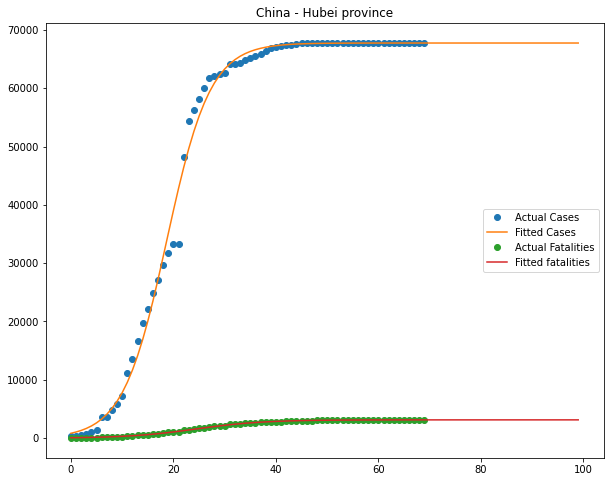

In [ ]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'China'][train_["Province_State"] == 'Hubei']['row_number']
y = train_[train_["Country_Region"] == 'China'][train_["Province_State"] == 'Hubei']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'China'][train_["Province_State"] == 'Hubei']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('China - Hubei province')
plt.legend(loc="center right")
plt.show()


Seems reasonable. Let's go ahead and test on the rest. Now lets create a dimensional lookup of the composite (Country_Region,Province_State) and fit curves to each of this tuple:

In [ ]:
unique = pd.DataFrame(train_.groupby(['Country_Region', 'Province_State'],as_index=False).count())


def date_day_diff(d1, d2):
    delta = dt.datetime.strptime(d1, "%Y-%m-%d") - dt.datetime.strptime(d2, "%Y-%m-%d")
    return delta.days

log_regions = []

for index, region in unique.iterrows():
    st = region['Province_State']
    co = region['Country_Region']
    
    rdata = train_[(train_['Province_State']==st) & (train_['Country_Region']==co)]

    t = rdata['Date'].values
    t = [float(date_day_diff(d, t[0])) for d in t]
    y = rdata['ConfirmedCases'].values
    y_ = rdata['Fatalities'].values

    p0 = [max(y), 0.0, max(t)]
    p0_ = [max(y_), 0.0, max(t)]
    try:
        popt, pcov = opt.curve_fit(logistic, t, y, p0, maxfev=10000)
        try:
            popt_, pcov_ = opt.curve_fit(logistic, t, y_, p0_, maxfev=10000)
        except:
            popt_, pcov_ = opt.curve_fit(f, t, y_,method="trf", maxfev=10000)
        log_regions.append((co,st,popt,popt_))
    except:
        popt, pcov = opt.curve_fit(f, t, y,method="trf", maxfev=10000)
        popt_, pcov_ = opt.curve_fit(f, t, y_,method="trf", maxfev=10000)
        log_regions.append((co,st,popt,popt_))

print("All done!")

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning:

overflow encountered in exp



All done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



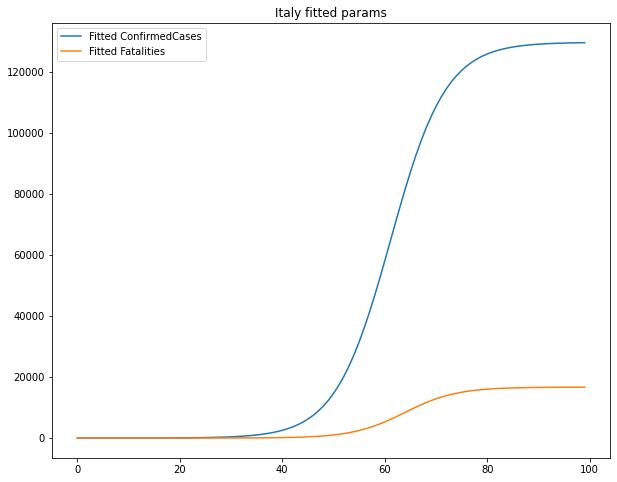

In [ ]:
log_regions = pd.DataFrame(log_regions)
log_regions.columns = ['Country_Region','Province_State','ConfirmedCases','Fatalities']

#Let us test graphing a curve from the fitted parameters:
T = np.arange(0, 100, 1).tolist()
popt = list(log_regions[log_regions["Country_Region"] == 'Italy'][log_regions["Province_State"] == 'Italy']['ConfirmedCases'])[0]
popt_ = list(log_regions[log_regions["Country_Region"] == 'Italy'][log_regions["Province_State"] == 'Italy']['Fatalities'])[0]

try:
    yfit = logistic(T, *popt)
    yfit_ = logistic(T, *popt_)
except:
    yfit = f(T, *popt)
    yfit_ = f(T, *popt_)
    

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(T, yfit, label="Fitted ConfirmedCases")
ax.plot(T, yfit_, label="Fitted Fatalities")
ax.title.set_text('Italy fitted params')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Generating submission file

submission = []

for index, rt in log_regions.iterrows():
    st = rt['Province_State']
    co = rt['Country_Region']
    popt = list(rt['ConfirmedCases'])
    popt_ = list(rt['Fatalities'])
    rtest = test[(test['Province_State']==st) & (test['Country_Region']==co)]
    for index, rt in rtest.iterrows():
        try:
            tdate = rt['Date']
            ca = logistic([date_day_diff(tdate, min(train_[(train_['Province_State']==st) & (train_['Country_Region']==co)]['Date'].values))], *popt)
            try:
                fa = logistic([date_day_diff(tdate, min(train_[(train_['Province_State']==st) & (train_['Country_Region']==co)]['Date'].values))], *popt_)
            except:
                fa = f([date_day_diff(tdate, min(train_[(train_['Province_State']==st) & (train_['Country_Region']==co)]['Date'].values))], *popt_)
            submission.append((rt['ForecastId'], int(ca[0]), int(fa[0])))
        except:
            tdate = rt['Date']
            ca = f([date_day_diff(tdate, min(train_[(train_['Province_State']==st) & (train_['Country_Region']==co)]['Date'].values))], *popt)
            fa = f([date_day_diff(tdate, min(train_[(train_['Province_State']==st) & (train_['Country_Region']==co)]['Date'].values))], *popt_)
            submission.append((rt['ForecastId'], int(ca[0]), int(fa[0])))

submission = pd.DataFrame(submission)
submission.columns = ['ForecastId','ConfirmedCases','Fatalities']
submission.to_csv('./submission.csv', index = False)
print("submission ready!")

submission ready!


# XGBoost

##Initial Cleaning and Transforming


In [ ]:
#Reading in files from JHU 4/23/2020
df_cases = pd.read_csv('/content/drive/My Drive/COVID19/JHU-4-23-2020/time_series_covid19_confirmed_global.csv')
df_recovered = pd.read_csv('/content/drive/My Drive/COVID19/JHU-4-23-2020/time_series_covid19_deaths_global.csv')
df_deaths = pd.read_csv('/content/drive/My Drive/COVID19/JHU-4-23-2020/time_series_covid19_recovered_global.csv')

In [ ]:
df_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25


In [ ]:
n_days = len(df_cases.drop(['Lat','Long','Province/State'],axis=1).groupby(['Country/Region']).sum().transpose())
n_days

93

In [ ]:
#Filling the Nan's with whitespace and putting % in Country/Region
df_cases['Province/State'] = df_cases['Province/State'].fillna('')
df_cases['Country/Region'] = df_cases['Country/Region']+ '%' + df_cases['Province/State']
df_deaths['Province/State'] = df_deaths['Province/State'].fillna('')
df_deaths['Country/Region'] = df_deaths['Country/Region']+ '%' + df_deaths['Province/State']
df_recovered['Province/State'] = df_recovered['Province/State'].fillna('')
df_recovered['Country/Region'] = df_recovered['Country/Region']+ '%' + df_recovered['Province/State']


In [ ]:
df_cases.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,,Afghanistan%,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279
1,,Albania%,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663
2,,Algeria%,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007
3,,Andorra%,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723
4,,Angola%,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25
5,,Antigua and Barbuda%,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7,7,7,7,9,15,15,15,15,19,19,19,19,21,21,23,23,23,23,23,23,23,23,23,24,24
6,,Argentina%,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265,1451,1451,1554,1628,1715,1795,1975,1975,2142,2208,2277,2443,2571,2669,2758,2839,2941,3031,3144,3435
7,,Armenia%,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736,770,822,833,853,881,921,937,967,1013,1039,1067,1111,1159,1201,1248,1291,1339,1401,1473,1523
8,Australian Capital Territory,Australia%Australian Capital Territory,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77,78,80,84,87,91,93,96,96,96,99,100,103,103,103,102,103,103,103,103,103,103,103,103,103,104
9,New South Wales,Australia%New South Wales,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389,2493,2580,2637,2686,2734,2773,2822,2857,2857,2863,2870,2886,2897,2926,2926,2926,2926,2926,2926,2976


In [ ]:
#total_tests csv is missing some rows! need to add Burma
print(len(df_cases))
print(len(df_deaths))
print(len(df_recovered))

264
250
264


## XGBoost with lag from last 5 days


In [ ]:
full_df = pd.read_csv('/content/drive/My Drive/COVID19/rows_by_date.csv')

In [ ]:
full_df_with_lag = full_df.sort_values(['index'],ascending=False)
full_df_with_lag.head()

,Unnamed: 0,Confirmed,Deaths,Recovered,index,Country
24551,24551,28.0,4.0,2.0,04/23/2020,Zimbabwe%
14135,14135,12368.0,328.0,1494.0,04/23/2020,Japan%
2975,2975,138.0,1.0,119.0,04/23/2020,Brunei%
21575,21575,42.0,3.0,6.0,04/23/2020,Syria%
1859,1859,2217.0,8.0,1082.0,04/23/2020,Bahrain%


In [ ]:
full_df_with_lag = full_df_with_lag.rename(columns={'index':'Date'})
full_df_with_lag['Index'] = full_df_with_lag.index


#use data on past 5 days !
for i in range(1,6): 
  confirmed_col_name = 'Confirmed_t-'+str(i)
  deaths_col_name = 'Deaths_t-'+str(i)
  recovered_col_name = 'Recovered_t-'+str(i)
  full_df_with_lag[confirmed_col_name] = None
  full_df_with_lag[deaths_col_name] = None
  full_df_with_lag[recovered_col_name] = None

full_df_with_lag.head()




,Unnamed: 0,Confirmed,Deaths,Recovered,Date,Country,Index,Confirmed_t-1,Deaths_t-1,Recovered_t-1,Confirmed_t-2,Deaths_t-2,Recovered_t-2,Confirmed_t-3,Deaths_t-3,Recovered_t-3,Confirmed_t-4,Deaths_t-4,Recovered_t-4,Confirmed_t-5,Deaths_t-5,Recovered_t-5
24551,24551,28.0,4.0,2.0,04/23/2020,Zimbabwe%,24551,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
14135,14135,12368.0,328.0,1494.0,04/23/2020,Japan%,14135,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2975,2975,138.0,1.0,119.0,04/23/2020,Brunei%,2975,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
21575,21575,42.0,3.0,6.0,04/23/2020,Syria%,21575,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1859,1859,2217.0,8.0,1082.0,04/23/2020,Bahrain%,1859,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
def get_confirmed(df, time, country, lag):
  current_date = pd.to_datetime(time)
  lag_date = (current_date - pd.to_timedelta(lag, unit='d')).strftime('%m/%d/%Y')
  return df[(df.Date == lag_date) & (df.Country == country)].iloc[0]['Confirmed']

def get_deaths(df, time, country, lag):
  current_date = pd.to_datetime(time)
  lag_date = (current_date - pd.to_timedelta(lag, unit='d')).strftime('%m/%d/%Y')
  return df[(df.Date == lag_date) & (df.Country == country)].iloc[0]['Deaths']

def get_recovered(df, time, country, lag):
  current_date = pd.to_datetime(time)
  lag_date = (current_date - pd.to_timedelta(lag, unit='d')).strftime('%m/%d/%Y')
  return df[(df.Date == lag_date) & (df.Country == country)].iloc[0]['Recovered']


In [ ]:
#For lag of 5, takes 25 minutes

dates = list(set(full_df_with_lag.Date.values))
dates.sort()
for idx in full_df_with_lag.index.values:
  date = full_df_with_lag[full_df_with_lag.Index == idx].iloc[0]['Date']
  country = full_df_with_lag[full_df_with_lag.Index == idx].iloc[0]['Country']
  if date in dates[5:]: #THE 5 earliest dates can't have lag. The list is ordered by ascending date
    for t in range(1,6):#5 days of lag
      confirmed_col_name = 'Confirmed_t-'+str(t)
      deaths_col_name = 'Deaths_t-'+str(t)
      recovered_col_name = 'Recovered_t-'+str(t)
      full_df_with_lag.at[idx,confirmed_col_name] = get_confirmed(full_df_with_lag,date,country,t)
      full_df_with_lag.at[idx,deaths_col_name] = get_deaths(full_df_with_lag,date,country,t)
      full_df_with_lag.at[idx,recovered_col_name] = get_recovered(full_df_with_lag,date,country,t)
      

In [ ]:
#full_df_with_lag.to_csv('full_df_with_lag_5.csv')

In [ ]:
full_df_with_lag = pd.read_csv('/content/drive/My Drive/COVID19/full_df_with_lag_5.csv')

In [ ]:
## For experimenting with lag 20

def save_for_lag_20():
  full_df_with_lag = full_df.sort_values(['index'],ascending=False)
  full_df_with_lag = full_df_with_lag.rename(columns={'index':'Date'})
  full_df_with_lag['Index'] = full_df_with_lag.index

  for i in range(1,21):#use data on past 20 days ! 
    confirmed_col_name = 'Confirmed_t-'+str(i)
    deaths_col_name = 'Deaths_t-'+str(i)
    recovered_col_name = 'Recovered_t-'+str(i)
    stringency_col_name = 'Stringency_t-'+str(i)
    testing_col_name = 'Testing_t-'+str(i)
    full_df_with_lag[confirmed_col_name] = None
    full_df_with_lag[deaths_col_name] = None
    full_df_with_lag[recovered_col_name] = None
    full_df_with_lag[stringency_col_name] = None
    full_df_with_lag[testing_col_name] = None

  dates = list(set(full_df_with_lag.Date.values))
  dates.sort()
  for idx in full_df_with_lag.index.values:
    date = full_df_with_lag[full_df_with_lag.Index == idx].iloc[0]['Date']
    country = full_df_with_lag[full_df_with_lag.Index == idx].iloc[0]['Country']
    if date in dates[20:]: #THE 20 earliest dates can't have lag. The list is ordered by ascending date
      for t in range(1,21):#20 days of lag
        confirmed_col_name = 'Confirmed_t-'+str(t)
        deaths_col_name = 'Deaths_t-'+str(t)
        recovered_col_name = 'Recovered_t-'+str(t)
        stringency_col_name = 'Stringency_t-'+str(t)
        testing_col_name = 'Testing_t-'+str(t)
        full_df_with_lag.at[idx,confirmed_col_name] = get_confirmed(full_df_with_lag,date,country,t)
        full_df_with_lag.at[idx,deaths_col_name] = get_deaths(full_df_with_lag,date,country,t)
        full_df_with_lag.at[idx,recovered_col_name] = get_recovered(full_df_with_lag,date,country,t)
        full_df_with_lag.at[idx,stringency_col_name] = get_stringency(full_df_with_lag,date,country,t)
        full_df_with_lag.at[idx,testing_col_name] = get_testing(full_df_with_lag,date,country,t)
  full_df_with_lag.to_csv('full_df_with_lag_20.csv')
  return 1

#save_for_lag_20()

In [ ]:

## For experimenting with lag 50

def save_for_lag_50():
  full_df_with_lag = full_df.sort_values(['index'],ascending=False)
  full_df_with_lag = full_df_with_lag.rename(columns={'index':'Date'})
  full_df_with_lag['Index'] = full_df_with_lag.index

  for i in range(1,51):#use data on past 50 days ! 
    confirmed_col_name = 'Confirmed_t-'+str(i)
    deaths_col_name = 'Deaths_t-'+str(i)
    recovered_col_name = 'Recovered_t-'+str(i)
    stringency_col_name = 'Stringency_t-'+str(i)
    testing_col_name = 'Testing_t-'+str(i)
    full_df_with_lag[confirmed_col_name] = None
    full_df_with_lag[deaths_col_name] = None
    full_df_with_lag[recovered_col_name] = None
    full_df_with_lag[stringency_col_name] = None
    full_df_with_lag[testing_col_name] = None

  dates = list(set(full_df_with_lag.Date.values))
  dates.sort()
  for idx in full_df_with_lag.index.values:
    date = full_df_with_lag[full_df_with_lag.Index == idx].iloc[0]['Date']
    country = full_df_with_lag[full_df_with_lag.Index == idx].iloc[0]['Country']
    if date in dates[50:]: #THE 50 earliest dates can't have lag. The list is ordered by ascending date
      for t in range(1,51):#50 days of lag
        confirmed_col_name = 'Confirmed_t-'+str(t)
        deaths_col_name = 'Deaths_t-'+str(t)
        recovered_col_name = 'Recovered_t-'+str(t)
        stringency_col_name = 'Stringency_t-'+str(t)
        testing_col_name = 'Testing_t-'+str(t)
        full_df_with_lag.at[idx,confirmed_col_name] = get_confirmed(full_df_with_lag,date,country,t)
        full_df_with_lag.at[idx,deaths_col_name] = get_deaths(full_df_with_lag,date,country,t)
        full_df_with_lag.at[idx,recovered_col_name] = get_recovered(full_df_with_lag,date,country,t)
        full_df_with_lag.at[idx,stringency_col_name] = get_stringency(full_df_with_lag,date,country,t)
        full_df_with_lag.at[idx,testing_col_name] = get_testing(full_df_with_lag,date,country,t)
  full_df_with_lag.to_csv('full_df_with_lag_50.csv')
  return 1

#save_for_lag_50()

In [ ]:
full_df_with_lag_clean = full_df_with_lag

In [ ]:
## Creating train and test sets

X_train = full_df_with_lag_clean[full_df_with_lag_clean.Date < "04/07/2020"]
X_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/15/2020"]
print(np.shape(X_train))
print(np.shape(X_test))

(20064, 22)
(264, 22)


In [ ]:
X_train.head()

,Unnamed: 0,Confirmed,Deaths,Recovered,Date,Country,Index,Confirmed_t-1,Deaths_t-1,Recovered_t-1,Confirmed_t-2,Deaths_t-2,Recovered_t-2,Confirmed_t-3,Deaths_t-3,Recovered_t-3,Confirmed_t-4,Deaths_t-4,Recovered_t-4,Confirmed_t-5,Deaths_t-5,Recovered_t-5
4674,75,367.0,11.0,18.0,04/06/2020,Afghanistan%,75,349.0,7.0,15.0,299.0,7.0,10.0,281.0,6.0,10.0,273.0,6.0,10.0,237.0,4.0,5.0
4675,168,377.0,21.0,116.0,04/06/2020,Albania%,168,361.0,20.0,104.0,333.0,20.0,99.0,304.0,17.0,89.0,277.0,16.0,76.0,259.0,15.0,67.0
4695,261,1423.0,173.0,90.0,04/06/2020,Algeria%,261,1320.0,152.0,90.0,1251.0,130.0,90.0,1171.0,105.0,62.0,986.0,86.0,61.0,847.0,58.0,61.0
4659,354,525.0,21.0,31.0,04/06/2020,Andorra%,354,501.0,18.0,26.0,466.0,17.0,21.0,439.0,16.0,16.0,428.0,15.0,10.0,390.0,14.0,10.0
4696,447,16.0,2.0,2.0,04/06/2020,Angola%,447,14.0,2.0,2.0,10.0,2.0,2.0,8.0,2.0,1.0,8.0,2.0,1.0,8.0,2.0,1.0


In [ ]:
#Build the y_train and y_test sets
y_train = full_df_with_lag_clean[full_df_with_lag_clean.Date < "04/15/2020"]
y_train = y_train[y_train.Date >= "02/04/2020"]    #01/27/2020 is the first date in the dataframe, so the first date in y_train should be +6
print(np.shape(y_train))
y_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/23/2020"]
print(np.shape(y_test))
y_test.head()

(18744, 22)
(264, 22)


,Unnamed: 0,Confirmed,Deaths,Recovered,Date,Country,Index,Confirmed_t-1,Deaths_t-1,Recovered_t-1,Confirmed_t-2,Deaths_t-2,Recovered_t-2,Confirmed_t-3,Deaths_t-3,Recovered_t-3,Confirmed_t-4,Deaths_t-4,Recovered_t-4,Confirmed_t-5,Deaths_t-5,Recovered_t-5
0,24551,28.0,4.0,2.0,04/23/2020,Zimbabwe%,24551,28.0,4.0,2.0,28.0,3.0,2.0,25.0,3.0,2.0,25.0,3.0,2.0,25.0,3.0,2.0
1,14135,12368.0,328.0,1494.0,04/23/2020,Japan%,14135,11512.0,281.0,1356.0,11135.0,263.0,1239.0,10797.0,236.0,1159.0,10797.0,236.0,1159.0,10296.0,222.0,1069.0
2,2975,138.0,1.0,119.0,04/23/2020,Brunei%,2975,138.0,1.0,117.0,138.0,1.0,116.0,138.0,1.0,116.0,138.0,1.0,115.0,137.0,1.0,113.0
3,21575,42.0,3.0,6.0,04/23/2020,Syria%,21575,42.0,3.0,6.0,42.0,3.0,6.0,39.0,3.0,5.0,39.0,3.0,5.0,38.0,2.0,5.0
4,1859,2217.0,8.0,1082.0,04/23/2020,Bahrain%,1859,2027.0,7.0,1026.0,1973.0,7.0,784.0,1907.0,7.0,769.0,1881.0,7.0,759.0,1773.0,7.0,755.0


In [ ]:
print(X_train['Date'].head())
print(y_train['Date'].head())

4488    04/06/2020
4489    04/06/2020
4490    04/06/2020
4491    04/06/2020
4492    04/06/2020
Name: Date, dtype: object
2376    04/14/2020
2377    04/14/2020
2378    04/14/2020
2379    04/14/2020
2380    04/14/2020
Name: Date, dtype: object


We define the variables we will want to keep.

In [ ]:
variables_to_keep = ['Confirmed_t-'+str(t) for t in range(1,6)]+['Deaths_t-'+str(t) for t in range(1,6)]+['Recovered_t-'+str(t) for t in range(1,6)]
X_train = X_train[variables_to_keep].fillna(0).astype(int)
X_test = X_test[variables_to_keep].fillna(0).astype(int)
y_train[['Deaths']] = y_train[['Deaths']].astype(int)
y_test[['Deaths']] = y_test[['Deaths']].astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
y_train.Deaths

2376       393
2377         3
2378         6
2379         8
2380     21067
         ...  
21115        0
21116        0
21117        0
21118        1
21119        0
Name: Deaths, Length: 18744, dtype: int64

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
#clf = GridSearchCV(xgb.XGBRegressor(),param_grid={'max_depth':[10,20,50,100],'n_estimators':[20,50,100,200,500]})
#clf.fit(X_train, y_train.Confirmed)


In [ ]:
#clf.best_params_

{'max_depth': 10, 'n_estimators': 20}

In [ ]:
model = xgb.XGBRegressor(max_depth=10,n_estimators=20,objective='reg:squarederror')
model.fit(X_train,y_train.Deaths)
pred = model.predict(X_test)

In [ ]:
relative_errors = [np.abs(100*(list(y_test.Deaths)[i]-pred[i])/list(y_test.Deaths)[i]) for i in range(len(pred))]

In [ ]:
pd.DataFrame({'y_test':list(y_test.Confirmed),'pred':pred,'rel_error':relative_errors,'Country':y_test.Country}).to_csv('check5.csv')

In [ ]:
#Overall error on validation set
(sum(pred)-sum(list(y_test.Deaths)))/sum(list(y_test.Deaths))*100

-17.32690944769793

Underpredicting by 17%

In [ ]:
score_df = pd.DataFrame({'y_test':list(y_test.Confirmed),'pred':pred,'rel_error':relative_errors,'Country':y_test.Country})
score_df = score_df[score_df.pred >=100]
score_df['log_y'] = score_df['y_test'].apply(lambda x: np.log(x))
score_df['log_pred'] = score_df['pred'].apply(lambda x: np.log(x))
score_df['log_diff'] = score_df['log_y'] - score_df['log_pred']
score_df['squared_log_diff'] = score_df['log_diff'].apply(lambda x: x**2)
print(np.sum(score_df.squared_log_diff))
score_df.head()

In [ ]:
score_df.sort_values(by=['y_test'],ascending=[False]).head()


,y_test,pred,rel_error,Country,log_y,log_pred,log_diff,squared_log_diff
188,869170.0,18068.320312,63.830083,US%,13.675294,9.801915,3.873379,15.003062
128,213024.0,17599.443359,20.569376,Spain%,12.269160,9.775623,2.493538,6.217730
105,189973.0,17599.443359,31.114942,Italy%,12.154637,9.775623,2.379015,5.659711
79,158183.0,15380.979492,29.625826,France%,11.971508,9.640887,2.330621,5.431794
106,153129.0,10136.238281,81.815933,Germany%,11.939036,9.223872,2.715164,7.372114


## Generate April 15th DataFrame:


In [ ]:
confirmed_future = pd.read_csv('time_series_covid19_confirmed_global.csv')[['Province/State','Country/Region','Lat','Long']]
recovered_future = pd.read_csv('time_series_covid19_recovered_global.csv')[['Province/State','Country/Region','Lat','Long']]
deaths_future = pd.read_csv('time_series_covid19_deaths_global.csv')[['Province/State','Country/Region','Lat','Long']]

confirmed_future['5/1/20'] = 0
recovered_future['5/1/20'] = 0
deaths_future['5/1/20'] = 0


In [ ]:
cd ../

/content/drive/My Drive/COVID19


In [ ]:
confirmed_future.tail()

,Province/State,Country/Region,Lat,Long,5/1/20
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0
260,NaN,South Sudan,6.877000,31.307000,0
261,NaN,Western Sahara,24.215500,-12.885800,0
262,NaN,Sao Tome and Principe,0.186360,6.613081,0
263,NaN,Yemen,15.552727,48.516388,0


In [ ]:
X_train = full_df_with_lag_clean[full_df_with_lag_clean.Date <= "04/15/2020"]
y_train = full_df_with_lag_clean[full_df_with_lag_clean.Date <= "04/23/2020"]
y_train = y_train[y_train.Date >= "02/04/2020"]    #01/27/2020 is the first date in the dataframe, so the first date in y_train should be +8
print(np.shape(X_train))
print(np.shape(y_train))


(21120, 22)
(21120, 22)


In [ ]:
y_train.head(2)

,Unnamed: 0,Confirmed,Deaths,Recovered,Date,Country,Index,Confirmed_t-1,Deaths_t-1,Recovered_t-1,Confirmed_t-2,Deaths_t-2,Recovered_t-2,Confirmed_t-3,Deaths_t-3,Recovered_t-3,Confirmed_t-4,Deaths_t-4,Recovered_t-4,Confirmed_t-5,Deaths_t-5,Recovered_t-5
256,92,1279.0,42.0,179.0,04/23/2020,Afghanistan%,92,1176.0,40.0,166.0,1092.0,36.0,150.0,1026.0,36.0,135.0,996.0,33.0,131.0,933.0,30.0,112.0
18,185,663.0,27.0,385.0,04/23/2020,Albania%,185,634.0,27.0,356.0,609.0,26.0,345.0,584.0,26.0,327.0,562.0,26.0,314.0,548.0,26.0,302.0


In [ ]:
variables_to_keep = ['Confirmed_t-'+str(t) for t in range(1,6)]+['Deaths_t-'+str(t) for t in range(1,6)]+['Recovered_t-'+str(t) for t in range(1,6)]
X_train = X_train[variables_to_keep].fillna(0).astype(int)

In [ ]:
model_confirmed = xgb.XGBRegressor(max_depth=10,n_estimators=20)
model_confirmed.fit(X_train,y_train[['Confirmed']].astype(int))
model_recovered = xgb.XGBRegressor(max_depth=10,n_estimators=20)
model_recovered.fit(X_train,y_train[['Recovered']].fillna(0).astype(int))
model_deaths = xgb.XGBRegressor(max_depth=10,n_estimators=20)
model_deaths.fit(X_train,y_train[['Deaths']].fillna(0).astype(int))

[22:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
X_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/23/2020"][variables_to_keep]


In [ ]:
confirmed_predictions = model_confirmed.predict(X_test)
recovered_predictions = model_recovered.predict(X_test)
deaths_predictions = model_deaths.predict(X_test)

In [ ]:
pd.DataFrame({'confirmed_predictions':confirmed_predictions,'recovered_predictions':recovered_predictions,'deaths_predictions':deaths_predictions,'Country':y_test.Country}).to_csv('predictions.csv')

In [ ]:
a = pd.DataFrame({'confirmed_predictions':confirmed_predictions,'recovered_predictions':recovered_predictions,'deaths_predictions':deaths_predictions,'Country':y_test.Country})
a.head()

,confirmed_predictions,recovered_predictions,deaths_predictions,Country
256,1386.899536,377.222595,54.256081,Afghanistan%
18,637.744690,440.326538,34.751541,Albania%
80,3719.716309,1910.095825,554.645203,Algeria%
42,933.801025,449.333130,47.493599,Andorra%
205,63.328594,11.575194,3.983400,Angola%


In [ ]:
a[['confirmed_predictions','recovered_predictions','deaths_predictions']] = a[['confirmed_predictions','recovered_predictions','deaths_predictions']].astype(int)
a.head()

,confirmed_predictions,recovered_predictions,deaths_predictions,Country
256,1386,377,54,Afghanistan%
18,637,440,34,Albania%
80,3719,1910,554,Algeria%
42,933,449,47,Andorra%
205,63,11,3,Angola%


In [ ]:
a['Country/Region'] = a.Country.apply(lambda x : x.split('%')[0])
a['Province/State'] = a.Country.apply(lambda x : x.split('%')[1])
a.head(10)

,confirmed_predictions,recovered_predictions,deaths_predictions,Country,Country/Region,Province/State
256,1386,377,54,Afghanistan%,Afghanistan,
18,637,440,34,Albania%,Albania,
80,3719,1910,554,Algeria%,Algeria,
42,933,449,47,Andorra%,Andorra,
205,63,11,3,Angola%,Angola,
67,63,13,7,Antigua and Barbuda%,Antigua and Barbuda,
81,3581,1400,252,Argentina%,Argentina,
126,1517,1184,31,Armenia%,Armenia,
30,103,83,2,Australia%Australian Capital Territory,Australia,Australian Capital Territory
68,3128,1938,33,Australia%New South Wales,Australia,New South Wales


In [ ]:
confirmed = pd.merge(confirmed_future.fillna(''), a[["Country/Region","Province/State","confirmed_predictions"]].fillna(''), on=['Country/Region','Province/State'])[["Province/State","Country/Region","Lat","Long","confirmed_predictions"]].rename(columns={"confirmed_predictions":'5/1/20'})
recovered = pd.merge(recovered_future.fillna(''), a[["Country/Region","Province/State","recovered_predictions"]].fillna(''), on=['Country/Region','Province/State'])[["Province/State","Country/Region","Lat","Long","recovered_predictions"]].rename(columns={"recovered_predictions":'5/1/20'})
deaths = pd.merge(deaths_future.fillna(''), a[["Country/Region","Province/State","deaths_predictions"]].fillna(''), on=['Country/Region','Province/State'])[["Province/State","Country/Region","Lat","Long","deaths_predictions"]].rename(columns={"deatbs_predictions":'5/1/20'})
confirmed.to_csv('time_series_covid19_confirmed_global_future.csv')
recovered.to_csv('time_series_covid19_recovered_global_future.csv')
deaths.to_csv('time_series_covid19_deaths_global_future.csv')

In [ ]:
a

,confirmed_predictions,recovered_predictions,deaths_predictions,Country,Country/Region,Province/State
256,1386,377,54,Afghanistan%,Afghanistan,
18,637,440,34,Albania%,Albania,
80,3719,1910,554,Algeria%,Algeria,
42,933,449,47,Andorra%,Andorra,
205,63,11,3,Angola%,Angola,
...,...,...,...,...,...,...
179,552,186,6,West Bank and Gaza%,West Bank and Gaza,
195,24,0,0,Western Sahara%,Western Sahara,
101,10,0,0,Yemen%,Yemen,
132,148,47,4,Zambia%,Zambia,


In [ ]:
b = confirmed_future.copy()
b[["Country","predictions"]] = a[["Country","confirmed_predictions"]].sort_values(['Country'])
b.to_csv('pred.csv')

## 12% error on total sum! meh



In [ ]:
X_train = full_df_with_lag_clean[full_df_with_lag_clean.Date < "04/08/2020"]
X_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/14/2020"]

#Build the y_train and y_test sets
y_train = full_df_with_lag_clean[full_df_with_lag_clean.Date < "04/14/2020"]
y_train = y_train[y_train.Date >= "02/02/2020"]    #01/27/2020 is the first date in the dataframe, so the first date in y_train should be +6

y_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/20/2020"]

variables_to_keep = ['Confirmed_t-'+str(t) for t in range(1,6)]+['Deaths_t-'+str(t) for t in range(1,6)]+['Recovered_t-'+str(t) for t in range(1,6)]+['Stringency_t-'+str(t) for t in range(1,6)]
X_train = X_train[variables_to_keep].fillna(0).astype(int)
X_test = X_test[variables_to_keep].fillna(0).astype(int)
y_train = y_train[['Confirmed']].astype(int)
y_test = y_test[['Confirmed']].astype(int)


model = xgb.XGBRegressor(max_depth=10,n_estimators=500)
model.fit(X_train,y_train)
pred = model.predict(X_test)
pd.DataFrame({'y_test':list(y_test.Confirmed),'pred':pred}).head(10)

[14:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,y_test,pred
0,1026,1268.672729
1,584,637.230347
2,2718,4089.044189
3,717,1106.724854
4,24,28.879673
5,23,68.466522
6,2941,4166.345703
7,1339,2008.687256
8,6547,10689.571289
9,14795,42816.187500


## Using past 20 days

In [ ]:
full_df_with_lag_clean = pd.read_csv('full_df_with_lag_20.csv')
print(np.shape(full_df_with_lag_clean))
full_df_with_lag_clean = full_df_with_lag_clean.dropna(subset=['Confirmed_t-20'])
print(np.shape(full_df_with_lag_clean))
full_df_with_lag_clean = full_df_with_lag_clean.sort_values(["Date", "Country"], ascending = (False, True))
full_df_with_lag_clean.head(10)

(16650, 109)
(12950, 109)


,Unnamed: 0,Confirmed,Deaths,Recovered,Stringency,Testing,Date,Country,Index,Confirmed_t-1,Deaths_t-1,Recovered_t-1,Stringency_t-1,Testing_t-1,Confirmed_t-2,Deaths_t-2,Recovered_t-2,Stringency_t-2,Testing_t-2,Confirmed_t-3,Deaths_t-3,Recovered_t-3,Stringency_t-3,Testing_t-3,Confirmed_t-4,Deaths_t-4,Recovered_t-4,Stringency_t-4,Testing_t-4,Confirmed_t-5,Deaths_t-5,Recovered_t-5,Stringency_t-5,Testing_t-5,Confirmed_t-6,Deaths_t-6,Recovered_t-6,Stringency_t-6,Testing_t-6,Confirmed_t-7,...,Confirmed_t-13,Deaths_t-13,Recovered_t-13,Stringency_t-13,Testing_t-13,Confirmed_t-14,Deaths_t-14,Recovered_t-14,Stringency_t-14,Testing_t-14,Confirmed_t-15,Deaths_t-15,Recovered_t-15,Stringency_t-15,Testing_t-15,Confirmed_t-16,Deaths_t-16,Recovered_t-16,Stringency_t-16,Testing_t-16,Confirmed_t-17,Deaths_t-17,Recovered_t-17,Stringency_t-17,Testing_t-17,Confirmed_t-18,Deaths_t-18,Recovered_t-18,Stringency_t-18,Testing_t-18,Confirmed_t-19,Deaths_t-19,Recovered_t-19,Stringency_t-19,Testing_t-19,Confirmed_t-20,Deaths_t-20,Recovered_t-20,Stringency_t-20,Testing_t-20
132,89,1026.0,36.0,135.0,0.0,0.0,04/20/2020,Afghanistan,89,996.0,33.0,131.0,0.0,0.0,933.0,30.0,112.0,71.0,0.0,906.0,30.0,99.0,71.0,0.0,840.0,30.0,54.0,71.0,0.0,784.0,25.0,43.0,71.0,0.0,714.0,23.0,40.0,71.0,0.0,665.0,...,423.0,14.0,18.0,71.0,0.0,367.0,11.0,18.0,71.0,0.0,349.0,7.0,15.0,71.0,0.0,299.0,7.0,10.0,71.0,0.0,281.0,6.0,10.0,71.0,0.0,273.0,6.0,10.0,71.0,0.0,237.0,4.0,5.0,71.0,0.0,174.0,4.0,5.0,71.0,0.0
31,202,584.0,26.0,327.0,86.0,0.0,04/20/2020,Albania,202,562.0,26.0,314.0,86.0,0.0,548.0,26.0,302.0,86.0,0.0,539.0,26.0,283.0,86.0,0.0,518.0,26.0,277.0,86.0,0.0,494.0,25.0,251.0,86.0,0.0,475.0,24.0,248.0,86.0,0.0,467.0,...,383.0,22.0,131.0,86.0,0.0,377.0,21.0,116.0,86.0,0.0,361.0,20.0,104.0,86.0,0.0,333.0,20.0,99.0,86.0,0.0,304.0,17.0,89.0,86.0,0.0,277.0,16.0,76.0,86.0,0.0,259.0,15.0,67.0,86.0,0.0,243.0,15.0,52.0,86.0,0.0
108,315,2718.0,384.0,1099.0,0.0,0.0,04/20/2020,Algeria,315,2629.0,375.0,1047.0,0.0,0.0,2534.0,367.0,894.0,0.0,0.0,2418.0,364.0,846.0,0.0,0.0,2268.0,348.0,783.0,0.0,0.0,2160.0,336.0,708.0,0.0,0.0,2070.0,326.0,691.0,0.0,0.0,1983.0,...,1468.0,193.0,113.0,95.0,0.0,1423.0,173.0,90.0,95.0,0.0,1320.0,152.0,90.0,95.0,0.0,1251.0,130.0,90.0,90.0,0.0,1171.0,105.0,62.0,90.0,0.0,986.0,86.0,61.0,90.0,0.0,847.0,58.0,61.0,90.0,0.0,716.0,44.0,46.0,86.0,0.0
122,428,717.0,37.0,248.0,0.0,0.0,04/20/2020,Andorra,428,713.0,36.0,235.0,0.0,0.0,704.0,35.0,205.0,0.0,0.0,696.0,35.0,191.0,0.0,0.0,673.0,33.0,169.0,0.0,0.0,673.0,33.0,169.0,0.0,0.0,659.0,31.0,128.0,0.0,0.0,646.0,...,545.0,22.0,39.0,57.0,0.0,525.0,21.0,31.0,57.0,0.0,501.0,18.0,26.0,57.0,0.0,466.0,17.0,21.0,57.0,0.0,439.0,16.0,16.0,57.0,0.0,428.0,15.0,10.0,57.0,0.0,390.0,14.0,10.0,57.0,0.0,376.0,12.0,10.0,57.0,0.0
88,541,24.0,2.0,6.0,0.0,0.0,04/20/2020,Angola,541,24.0,2.0,6.0,0.0,0.0,24.0,2.0,6.0,0.0,0.0,19.0,2.0,5.0,0.0,0.0,19.0,2.0,5.0,71.0,0.0,19.0,2.0,5.0,71.0,0.0,19.0,2.0,5.0,71.0,0.0,19.0,...,17.0,2.0,2.0,71.0,0.0,16.0,2.0,2.0,71.0,0.0,14.0,2.0,2.0,71.0,0.0,10.0,2.0,2.0,71.0,0.0,8.0,2.0,1.0,71.0,0.0,8.0,2.0,1.0,71.0,0.0,8.0,2.0,1.0,71.0,0.0,7.0,2.0,1.0,71.0,0.0
84,654,23.0,3.0,3.0,0.0,0.0,04/20/2020,Antigua and Barbuda,654,23.0,3.0,3.0,0.0,0.0,23.0,3.0,3.0,0.0,0.0,23.0,3.0,3.0,0.0,0.0,23.0,3.0,3.0,0.0,0.0,23.0,2.0,3.0,0.0,0.0,23.0,2.0,3.0,0.0,0.0,23.0,...,19.0,1.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
78,767,2941.0,136.0,737.0,0.0,34568.0,04/20/2020,Argentina,767,2839.0,132.0,709.0,0.0,32712.0,2758.0,129.0,685.0,0.0,30942.0,2669.0,123.0,666.0,0.0,28650.0,2571.0,115.0,631.0,95.0,26457.0,2443.0,111.0,596.0,95.0,24374.0,2277.0,102.0,559.0,95.0,22805.0,2208.0,...,1628.0,56.0,338.0,95.0,0.0,1554.0,48.0,325.0,95.0,0.0,1451.0,44.0,280.0,95.0,0.0,1451.0,43.0,279.0,95.0,0.0,1265.0,39.0,266.0,90.0,0.0,1133.0,36.0,256.0,90.0,0.0,1054.0,28.0,248.0,90.0,0.0,1054.0,27.0,240.0,95.0,0.0
74,880,1339.0,22.0,580.0,0.0,0.0,04/20/202

In [ ]:
print(np.shape(full_df_with_lag_clean.dropna(subset=['Confirmed_t-1'])))
print(full_df_with_lag_clean['Date'].min())

(12950, 109)
02/11/2020


In [ ]:
X_train = full_df_with_lag_clean[full_df_with_lag_clean.Date < "04/08/2020"]
X_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/14/2020"]

#Build the y_train and y_test sets
y_train = full_df_with_lag_clean[full_df_with_lag_clean.Date < "04/14/2020"]
y_train = y_train[y_train.Date >= "02/17/2020"]    #02/11/2020 is the first date in the dataframe, so the first date in y_train should be +6

y_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/20/2020"]
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(10545, 109)
(185, 109)
(10545, 109)
(185, 109)


In [ ]:
X_train.head()

,Unnamed: 0,Confirmed,Deaths,Recovered,Stringency,Testing,Date,Country,Index,Confirmed_t-1,Deaths_t-1,Recovered_t-1,Stringency_t-1,Testing_t-1,Confirmed_t-2,Deaths_t-2,Recovered_t-2,Stringency_t-2,Testing_t-2,Confirmed_t-3,Deaths_t-3,Recovered_t-3,Stringency_t-3,Testing_t-3,Confirmed_t-4,Deaths_t-4,Recovered_t-4,Stringency_t-4,Testing_t-4,Confirmed_t-5,Deaths_t-5,Recovered_t-5,Stringency_t-5,Testing_t-5,Confirmed_t-6,Deaths_t-6,Recovered_t-6,Stringency_t-6,Testing_t-6,Confirmed_t-7,...,Confirmed_t-13,Deaths_t-13,Recovered_t-13,Stringency_t-13,Testing_t-13,Confirmed_t-14,Deaths_t-14,Recovered_t-14,Stringency_t-14,Testing_t-14,Confirmed_t-15,Deaths_t-15,Recovered_t-15,Stringency_t-15,Testing_t-15,Confirmed_t-16,Deaths_t-16,Recovered_t-16,Stringency_t-16,Testing_t-16,Confirmed_t-17,Deaths_t-17,Recovered_t-17,Stringency_t-17,Testing_t-17,Confirmed_t-18,Deaths_t-18,Recovered_t-18,Stringency_t-18,Testing_t-18,Confirmed_t-19,Deaths_t-19,Recovered_t-19,Stringency_t-19,Testing_t-19,Confirmed_t-20,Deaths_t-20,Recovered_t-20,Stringency_t-20,Testing_t-20
2580,76,423.0,14.0,18.0,71.0,0.0,04/07/2020,Afghanistan,76,367.0,11.0,18.0,71.0,0.0,349.0,7.0,15.0,71.0,0.0,299.0,7.0,10.0,71.0,0.0,281.0,6.0,10.0,71.0,0.0,273.0,6.0,10.0,71.0,0.0,237.0,4.0,5.0,71.0,0.0,174.0,...,84.0,2.0,2.0,52.0,0.0,74.0,1.0,1.0,52.0,0.0,40.0,1.0,1.0,43.0,0.0,40.0,1.0,1.0,43.0,0.0,24.0,0.0,1.0,43.0,0.0,24.0,0.0,1.0,43.0,0.0,22.0,0.0,1.0,43.0,0.0,22.0,0.0,1.0,43.0,0.0
2554,189,383.0,22.0,131.0,86.0,0.0,04/07/2020,Albania,189,377.0,21.0,116.0,86.0,0.0,361.0,20.0,104.0,86.0,0.0,333.0,20.0,99.0,86.0,0.0,304.0,17.0,89.0,86.0,0.0,277.0,16.0,76.0,86.0,0.0,259.0,15.0,67.0,86.0,0.0,243.0,...,146.0,5.0,17.0,86.0,0.0,123.0,5.0,10.0,86.0,0.0,104.0,4.0,2.0,86.0,0.0,89.0,2.0,2.0,86.0,0.0,76.0,2.0,2.0,86.0,0.0,70.0,2.0,0.0,86.0,0.0,64.0,2.0,0.0,86.0,0.0,59.0,2.0,0.0,86.0,0.0
2498,302,1468.0,193.0,113.0,95.0,0.0,04/07/2020,Algeria,302,1423.0,173.0,90.0,95.0,0.0,1320.0,152.0,90.0,95.0,0.0,1251.0,130.0,90.0,90.0,0.0,1171.0,105.0,62.0,90.0,0.0,986.0,86.0,61.0,90.0,0.0,847.0,58.0,61.0,90.0,0.0,716.0,...,302.0,21.0,65.0,86.0,0.0,264.0,19.0,24.0,86.0,0.0,230.0,17.0,65.0,86.0,0.0,201.0,17.0,65.0,76.0,0.0,139.0,15.0,32.0,57.0,0.0,90.0,11.0,32.0,57.0,0.0,87.0,9.0,32.0,48.0,0.0,74.0,7.0,12.0,48.0,0.0
2433,415,545.0,22.0,39.0,57.0,0.0,04/07/2020,Andorra,415,525.0,21.0,31.0,57.0,0.0,501.0,18.0,26.0,57.0,0.0,466.0,17.0,21.0,57.0,0.0,439.0,16.0,16.0,57.0,0.0,428.0,15.0,10.0,57.0,0.0,390.0,14.0,10.0,57.0,0.0,376.0,...,188.0,1.0,1.0,57.0,0.0,164.0,1.0,1.0,14.0,0.0,133.0,1.0,1.0,14.0,0.0,113.0,1.0,1.0,14.0,0.0,88.0,0.0,1.0,14.0,0.0,75.0,0.0,1.0,14.0,0.0,53.0,0.0,1.0,14.0,0.0,39.0,0.0,1.0,14.0,0.0
2472,528,17.0,2.0,2.0,71.0,0.0,04/07/2020,Angola,528,16.0,2.0,2.0,71.0,0.0,14.0,2.0,2.0,71.0,0.0,10.0,2.0,2.0,71.0,0.0,8.0,2.0,1.0,71.0,0.0,8.0,2.0,1.0,71.0,0.0,8.0,2.0,1.0,71.0,0.0,7.0,...,3.0,0.0,0.0,52.0,0.0,3.0,0.0,0.0,48.0,0.0,3.0,0.0,0.0,14.0,0.0,2.0,0.0,0.0,14.0,0.0,2.0,0.0,0.0,14.0,0.0,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,14.0,0.0


In [ ]:
variables_to_keep = ['Confirmed_t-'+str(t) for t in range(1,21)]+['Deaths_t-'+str(t) for t in range(1,21)]+['Recovered_t-'+str(t) for t in range(1,21)]
X_train = X_train[variables_to_keep].fillna(0).astype(int)
X_test = X_test[variables_to_keep].fillna(0).astype(int)
y_train = y_train[['Confirmed']].astype(int)
y_test = y_test[['Confirmed']].astype(int)


model = xgb.XGBRegressor(n_estimators=500,max_depth=10)
model.fit(X_train,y_train)
pred = model.predict(X_test)
pd.DataFrame({'y_test':list(y_test.Confirmed),'pred':pred}).head(20)

[14:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,y_test,pred
0,1026,1062.805542
1,584,701.903992
2,2718,3813.413818
3,717,1177.804688
4,24,60.278587
5,23,89.168221
6,2941,4165.836914
7,1339,1589.146729
8,6547,8246.436523
9,14795,21977.927734


In [ ]:
(sum(pred)-sum(list(y_test.Confirmed)))/sum(list(y_test.Confirmed))*100

8.56371232517927

In [ ]:
relative_errors = [int(np.abs(100*(list(y_test.Confirmed)[i]-pred[i])/list(y_test.Confirmed)[i])) for i in range(len(pred))]
print(np.median(relative_errors))

29.0


## Lag of past 50

In [ ]:
cd ../

/content/drive/My Drive/COVID19


In [ ]:
import pandas as pd
import 

In [ ]:
full_df_with_lag_clean = pd.read_csv('full_df_with_lag_50.csv')
print(np.shape(full_df_with_lag_clean))
full_df_with_lag_clean = full_df_with_lag_clean.dropna(subset=['Confirmed_t-20'])
print(np.shape(full_df_with_lag_clean))
full_df_with_lag_clean = full_df_with_lag_clean.sort_values(["Date", "Country"], ascending = (False, True))
print(np.shape(full_df_with_lag_clean.dropna(subset=['Confirmed_t-1'])))
print(full_df_with_lag_clean['Date'].min())

(16650, 259)
(7400, 259)
(7400, 259)
03/12/2020


In [ ]:
X_train = full_df_with_lag_clean[full_df_with_lag_clean.Date < "04/08/2020"]
X_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/14/2020"]

#Build the y_train and y_test sets
y_train = full_df_with_lag_clean[full_df_with_lag_clean.Date < "04/14/2020"]
y_train = y_train[y_train.Date >= "03/18/2020"]    #02/11/2020 is the first date in the dataframe, so the first date in y_train should be +6

y_test = full_df_with_lag_clean[full_df_with_lag_clean.Date == "04/20/2020"]
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(4995, 259)
(185, 259)
(4995, 259)
(185, 259)


In [ ]:
variables_to_keep = ['Confirmed_t-'+str(t) for t in range(1,21)]+['Deaths_t-'+str(t) for t in range(1,21)]+['Recovered_t-'+str(t) for t in range(1,21)]
X_train = X_train[variables_to_keep].fillna(0).astype(int)
X_test = X_test[variables_to_keep].fillna(0).astype(int)
y_train[['Confirmed']] = y_train[['Confirmed']].astype(int)
y_test[['Confirmed']] = y_test[['Confirmed']].astype(int)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
print(min(set(full_df_with_lag.Date.values)))
print(max(set(full_df_with_lag.Date.values)))
len(set(full_df_with_lag.Date.values))

01/22/2020
04/23/2020


93

1439     665.0
1474     467.0
1454    1983.0
1389     646.0
1350      19.0
         ...  
6195      41.0
6248       0.0
6133       0.0
6161       2.0
6231       0.0
Name: Confirmed, Length: 4995, dtype: float64

In [ ]:
model = xgb.XGBRegressor(n_estimators=500,max_depth=10)
model.fit(X_train,y_train['Confirmed'])
pred = model.predict(X_test)
pd.DataFrame({'y_test':list(y_test.Confirmed),'pred':pred,'country':list(y_test.Country)}).to_csv('check50.csv')

[15:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
relative_errors = [int(np.abs(100*(list(y_test.Confirmed)[i]-pred[i])/list(y_test.Confirmed)[i])) for i in range(len(pred))]
print(np.median(relative_errors))

33.0


In [ ]:
(sum(pred)-sum(list(y_test.Confirmed)))/sum(list(y_test.Confirmed))*100

6.2004335444017915

In [ ]:
ls

In [ ]:
check50 = pd.DataFrame({'y_test':list(y_test.Confirmed),'pred':pred,'country':list(y_test.Country)})
check50

In [ ]:
check50

,y_test,pred,country
0,1026.0,928.117065,Afghanistan
1,584.0,706.069397,Albania
2,2718.0,3563.331787,Algeria
3,717.0,1114.663086,Andorra
4,24.0,25.611967,Angola
...,...,...,...
180,449.0,439.531891,West Bank and Gaza
181,6.0,15.771783,Western Sahara
182,1.0,5.407446,Yemen
183,65.0,119.066292,Zambia


In [ ]:
cd

/root
